Comparing convergence using regular Bayesian Approach, Frequentist Approach and predictive Bayesian Approach.
Suppose we have the following observations:
- $x_{k,1}, x_{k,2}, \ldots, x_{k,n_k}$ are the observations from the $k$-th group.
- $k=1,..., K$.
- $n_k$ is the number of observations in the $k$-th group.
- Suppose $n_k = n$ for all $k$.
- The data is generated from a normal distribution with mean $\mu$ and variance $\sigma^2$ where $mu, \sigma \sim N(0, 1)$.
- The goal is to find the distribution of $\mu$ and $\sigma^2$ given the data.

In [1]:
import numpy as np
from scipy import stats
from src.utils import ecdf, ecdf_inv
%load_ext autoreload
%autoreload 2


## Simulating Data

In [2]:
# Simulation of a the data
K = 1
N = 1000
data = np.zeros((K, N))
sig2 = 1  # variance of the data
real_means = np.zeros(K)

# simulating exchangeable data for all groups
for k in range(K):
    # simulating the mean and variance of the k-th group
    mu_k = np.random.normal(0, 1)
    real_means[k] = mu_k
    # simulating the data for the k-th group
    data[k, :] = np.random.normal(mu_k, sig2, N)

# Tasks:
- Bayesian inference
    - Understand code
    - Write theoretical
- PA to Bayesian inference
    - Find code without prior
    - Compare performance


## Predictive Bayesian approach (predictive Resampling)

We observe data, incomplete for some groups. We want to know the distribution of the complete data. Under our assuptions, we only need to find the distribution of the $mu$. What we want is to do so without giving a prior distribution to $mu$. We test 2 cases, the second one, we give a prior dist $N(0,1)$ (which is also the correct one but we do not know it yet), and the first one we use the predictive approach with predictive resampling.

### How to sample $X_n$ from $\hat{F}_n$?
- We can sample $X_n$ from $\hat{F}_n$ using the following steps:
    1. Generate a random number $u$ from a uniform distribution on $(0, 1)$.
    2. Find the smallest $i$ such that $\hat{F}_n(i) \geq u$. In other words, this is the inverse of the ecdf.
    3. Set $X_n =$ `ecdf_inv`$(u)$.

### Predictive Resampling using ECDFs as strategy

In [8]:
from collections import defaultdict

iter = 100
nn = [100, 500, 1000, 2000]

mus = defaultdict(list)  # array to store values of mu
for _ in range(iter):
    for n in nn:
        samples = list(data[0, :])
        for _ in range(n):
            # X_new sim \hat{F}_n
            u = np.random.uniform(0,1)
            X_new = ecdf_inv(samples, u)
            samples.append(X_new)
        mus[n].append(np.mean(samples))

    


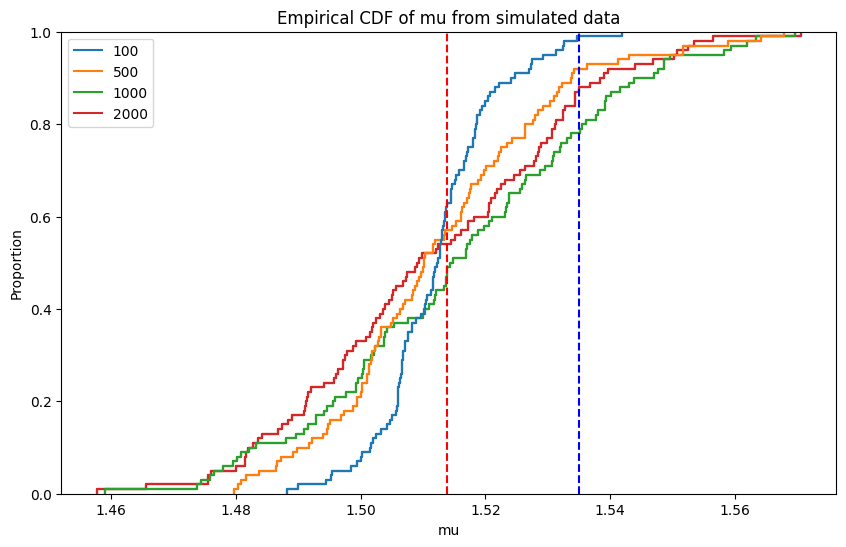

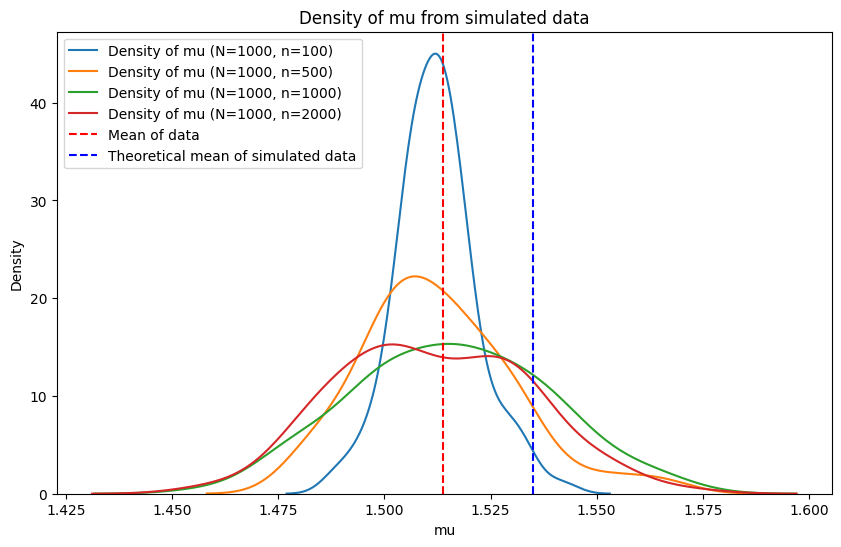

In [9]:
# Plotting distribution of mu
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
for n in nn:
    sns.ecdfplot(mus, stat="proportion", label=f"ECDF of mu (N={N}, n={n})")
plt.title("Empirical CDF of mu from simulated data")
plt.xlabel("mu")
plt.ylabel("Proportion")
plt.axvline(x=np.mean(data[0, :]), color='r', linestyle='--', label="Mean of data")
plt.axvline(x=real_means[0], color='b', linestyle='--', label="Theoretical mean of simulated data")
plt.show()

# Dessities plots
plt.figure(figsize=(10, 6))
for n in nn:
    sns.kdeplot(mus[n], label=f"Density of mu (N={N}, n={n})")
plt.title("Density of mu from simulated data")
plt.xlabel("mu")
plt.ylabel("Density")
plt.axvline(x=np.mean(data[0, :]), color='r', linestyle='--', label="Mean of data")
plt.axvline(x=real_means[0], color='b', linestyle='--', label="Theoretical mean of simulated data")
plt.legend()
plt.show()

We observe as expected that the more we increase $n$, the more our distribution is uncertain and has chances to give reasonable probabilities to our desired mean

### Traditional Bayesian Approach
- We select a prior distribution for the mean $\mu$.
- Say we start with a normal distribution with mean 0 and variance 1.


In [5]:
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu  1.514  0.031   1.458    1.575      0.001    0.001     770.0    1520.0   

    r_hat  
mu   1.01  


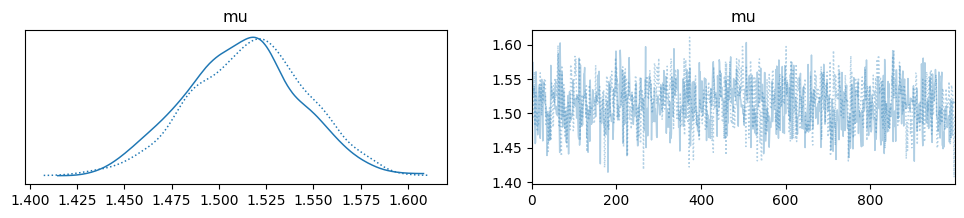

In [15]:
with pm.Model() as model_noninformative:
    # Priors (Non-informative, Jeffrey's priors)
    sigma = 1 #pm.HalfNormal('sigma', sigma=10)  # Weakly informative for variance
    mu = pm.Flat('mu')  # Flat prior for mean
    
    # Likelihood
    likelihood = pm.Normal('likelihood', mu=mu, sigma=sigma, observed=data[0, :])
    
    # Inference
    trace_noninformative = pm.sample(1000, tune=1000, cores=2)

# Summary and visualization
print(az.summary(trace_noninformative))
az.plot_trace(trace_noninformative)
plt.show()

In [ ]:
print(real_means[0])

1.535008115790099


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu  1.511  0.031   1.452    1.568      0.001    0.001     809.0    1440.0   

    r_hat  
mu    1.0  


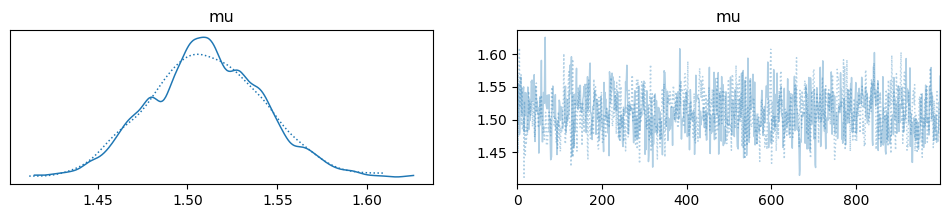

In [16]:
with pm.Model() as model_normal_prior:
    # Priors
    sigma = 1  #pm.HalfNormal('sigma', sigma=10)  # Still need prior for variance
    mu = pm.Normal('mu', mu=0, sigma=1)  # Normal(0, 1) prior for mean
    
    # Likelihood
    likelihood = pm.Normal('likelihood', mu=mu, sigma=sigma, observed=data)
    
    # Inference
    trace_normal_prior = pm.sample(1000, tune=1000, cores=2)

# Summary and visualization
print(az.summary(trace_normal_prior))
az.plot_trace(trace_normal_prior)
plt.show()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu  1.515  0.032   1.456    1.573      0.001    0.001     783.0    1349.0   

    r_hat  
mu    1.0  


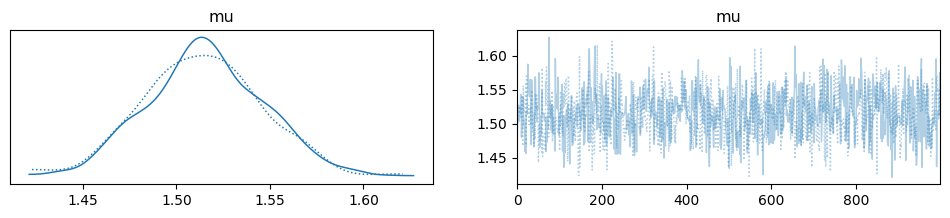

In [17]:
with pm.Model() as model_empirical_bayes:
    # Estimate parameters from data
    empirical_mean = np.mean(data)
    empirical_std = np.std(data)
    
    # Use these estimates to inform our priors
    mu = pm.Normal('mu', mu=empirical_mean, sigma=empirical_std)
    sigma = 1  #pm.HalfNormal('sigma', sigma=empirical_std)
    
    # Likelihood
    likelihood = pm.Normal('likelihood', mu=mu, sigma=sigma, observed=data)
    
    # Inference
    trace_empirical_bayes = pm.sample(1000, tune=1000, cores=2)

# Summary and visualization
print(az.summary(trace_empirical_bayes))
az.plot_trace(trace_empirical_bayes)
plt.show()

<Figure size 3000x2000 with 0 Axes>

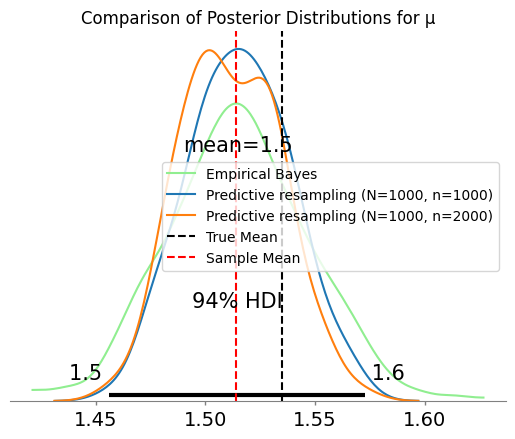

In [24]:
# Compare the posterior distributions
plt.figure(figsize=(30, 20))
# az.plot_posterior(trace_noninformative, var_names=['mu'], label='Non-informative Prior', color='skyblue')
# az.plot_posterior(trace_normal_prior, var_names=['mu'], label='Normal(0,1) Prior', color='salmon')
az.plot_posterior(trace_empirical_bayes, var_names=['mu'], label='Empirical Bayes', color='lightgreen')
# Predictive resampling
sns.kdeplot(mus[1000], label=f"Predictive resampling (N={N}, n={1000})")
sns.kdeplot(mus[2000], label=f"Predictive resampling (N={N}, n={2000})")
# Add vertical lines for the means
plt.axvline(real_means[0], color='k', linestyle='--', label='True Mean')
plt.axvline(np.mean(data[0, :]), color='r', linestyle='--', label='Sample Mean')
plt.title('Comparison of Posterior Distributions for μ')
plt.legend(loc="best")
plt.show()

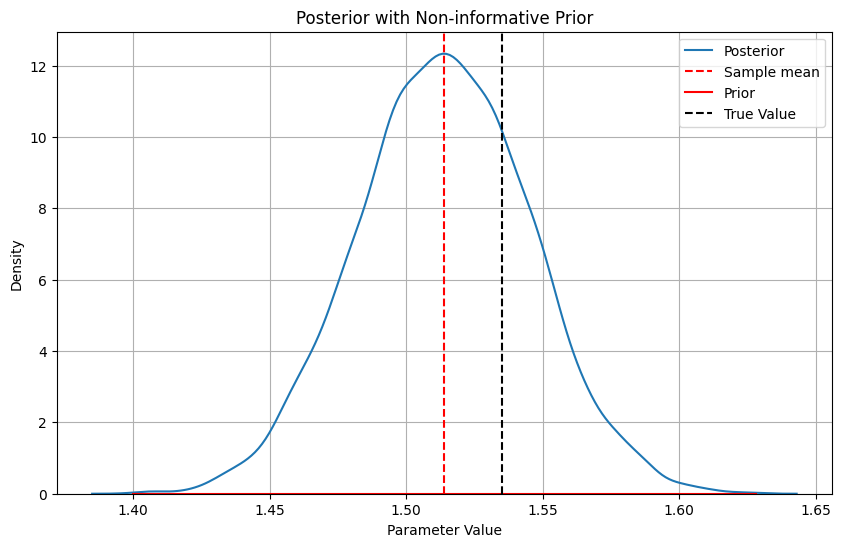

In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

def plot_posterior(samples, *, prior=None, true_value=None, title="Posterior Distribution"):
    """Plot the posterior distribution with optional prior and true value."""
    plt.figure(figsize=(10, 6))
    # posterior
    sns.kdeplot(samples, label='Posterior')
    # sample mean
    plt.axvline(np.mean(samples), color='r', linestyle='--', label='Sample mean')

    # Plotting prior if provided
    if prior is not None:
        x = np.linspace(min(samples), max(samples), 1000)
        plt.plot(x, prior.pdf(x), 'r-', label='Prior')
    
    # Plot true value if provided
    if true_value is not None:
        plt.axvline(true_value, color='k', linestyle='--', label='True Value')
    
    plt.title(title)
    plt.xlabel('Parameter Value')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

def bayesian_inference_noninformative(data, sigma=None, n_samples=10000):
    """Bayesian inference with non-informative prior."""
    n = len(data)
    sample_mean = np.mean(data)
    
    # If sigma is not known, estimate it from data
    if sigma is None:
        sigma = np.std(data, ddof=1)  # Sample standard deviation
    
    # Posterior parameters
    posterior_mean = sample_mean
    posterior_std = sigma / np.sqrt(n)
    
    # Generate samples from posterior
    posterior_samples = np.random.normal(posterior_mean, posterior_std, n_samples)
    
    return posterior_samples

# Example usage
posterior_noninformative = bayesian_inference_noninformative(data[0,:], sigma=1)
plot_posterior(posterior_noninformative, 
               prior=stats.norm(loc=0, scale=100),  # flat prior
               true_value=real_means[0],
               title="Posterior with Non-informative Prior")

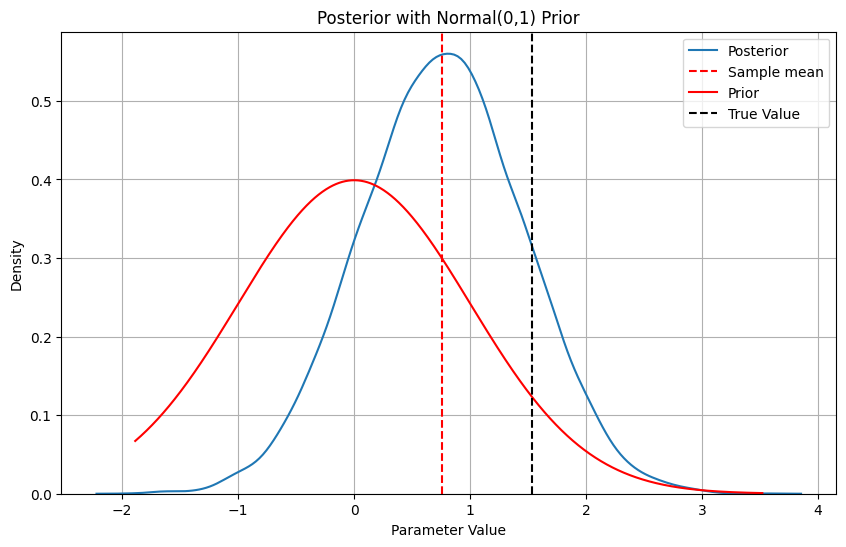

In [30]:
def bayesian_inference_normal_prior(data, prior_mu=0, prior_sigma=1, sigma=None, n_samples=10000):
    """Bayesian inference with normal prior."""
    n = len(data)
    sample_mean = np.mean(data)
    
    # If sigma is not known, estimate it from data
    if sigma is None:
        sigma = np.std(data, ddof=1)  # Sample standard deviation
    
    # Posterior parameters (conjugate update)
    posterior_var = 1 / (1/prior_sigma**2 + n/sigma**2)
    posterior_mean = posterior_var * (prior_mu/prior_sigma**2 + n*sample_mean/sigma**2)
    posterior_std = np.sqrt(posterior_var)
    
    # Generate samples from posterior
    posterior_samples = np.random.normal(posterior_mean, posterior_std, n_samples)
    
    return posterior_samples

# Example usage
posterior_normal_prior = bayesian_inference_normal_prior(data, sigma=1)
plot_posterior(posterior_normal_prior,
               prior=stats.norm(loc=0, scale=1),
               true_value=real_means[0],
               title="Posterior with Normal(0,1) Prior")

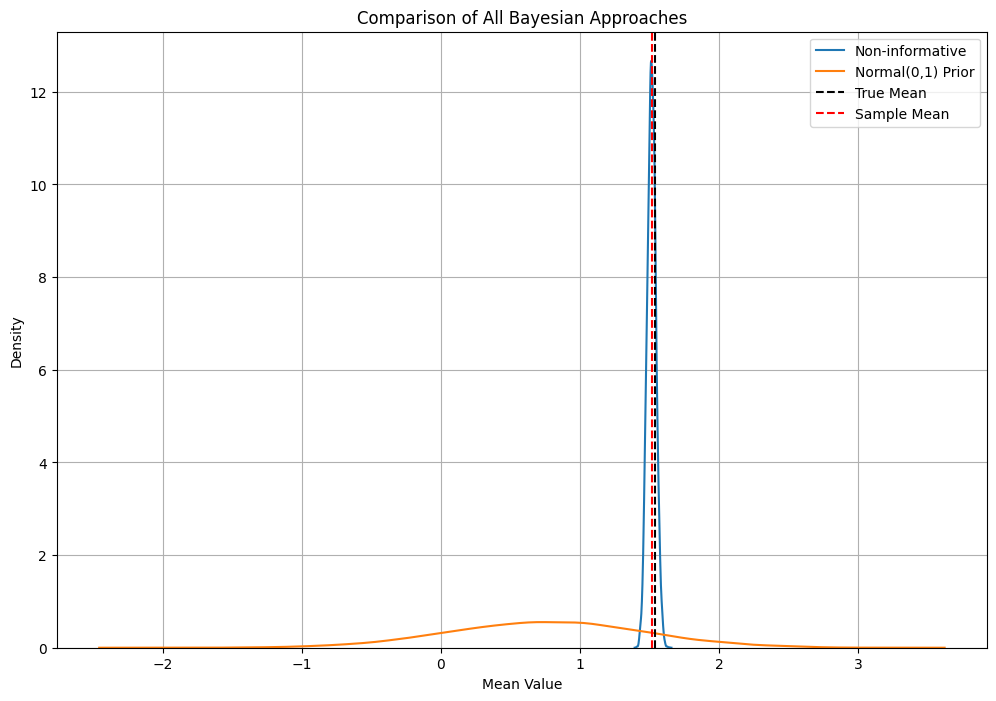

In [29]:
# Compare all posterior distributions
plt.figure(figsize=(12, 8))
sns.kdeplot(posterior_noninformative, label='Non-informative')
sns.kdeplot(posterior_normal_prior, label='Normal(0,1) Prior')
plt.axvline(real_means[0], color='k', linestyle='--', label='True Mean')
plt.axvline(np.mean(data[0,:]), color='r', linestyle='--', label='Sample Mean')
plt.title('Comparison of All Bayesian Approaches')
plt.xlabel('Mean Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()